# **Notebook 1: Protocolo de Extracción de Datos y Preparación del Dataset (Sampling)**
## Proyecto: Evaluación de Riesgo Arqueológico mediante Machine Learning
**Caso de Estudio:** Modelo Predictivo de Probabilidad de Hallazgos en el Territorio Peruano

**Autor:** Yishar Piero Nieto Barrientos  
**Repositorio de Investigación:** [Tu enlace de GitHub aquí]

---

### **Introducción**
Este notebook constituye la fase inicial del flujo de trabajo de **Ingeniería de Características (Feature Engineering)** aplicado a la arqueología preventiva[cite: 7]. El objetivo central es la transformación de datos geoespaciales continuos (Rasters) en una estructura de datos tabular (Dataframe) apta para algoritmos de aprendizaje supervisado[cite: 48, 58].

Mediante la técnica de **"Pixel Drilling"** o muestreo puntual multivariable, se extraen los valores de variables biofísicas y culturales en coordenadas específicas[cite: 50, 57]. Este proceso permite que el modelo identifique patrones de asentamiento basados en la habitabilidad y la proximidad a recursos estratégicos[cite: 19, 20].

### **Especificaciones Técnicas**
* **Resolución Espacial:** 30 x 30 metros por píxel, asegurando un balance entre precisión geográfica y eficiencia computacional.
* **Estrategia de Optimización:** Pre-cálculo de distancias euclidianas y variables derivadas en entorno GIS (Rasterización previa) para acelerar la inferencia en Python[cite: 4, 5, 6].
* **Variables Predictoras:** Topografía (Pendiente, Rugosidad), Hidrografía (Ríos, Lagos) y Redes Culturales (Qhapaq Ñan, Sitios Declarados)[cite: 21, 24, 28, 35, 39].

### **1. Instalacion de librerias**
Instalamos las librerías necesarias para el manejo de rasters y modelos predictivos.

In [ ]:
import os
import sys
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import rasterio
import fiona
import seaborn as sns

from shapely.geometry import Point
from shapely.prepared import prep # Truco de velocidad
from osgeo import gdal
from tqdm import tqdm

# Esto es para que los mapas se vean bonitos dentro del notebook
%matplotlib inline

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


### **2. Inventario de Variables y Fuentes de Datos**
Para garantizar la validez del modelo predictivo, se han seleccionado variables que responden a criterios de habitabilidad, acceso a recursos y conectividad arqueológica. Cada capa ha sido procesada con una resolución de 30 metros.

| Dominio | Variable ($X_n$) | Descripción Técnica | Hipótesis Arqueológica |
| :--- | :--- | :--- | :--- |
| **Topografía** | **Pendiente** | Grados de inclinación del terreno ($0^{\circ}-90^{\circ}$). | Terrenos planos o semi-planos son preferidos para habitación y agricultura. |
| **Topografía** | **Rugosidad (TRI)** | Índice de irregularidad del terreno. | Áreas menos rugosas facilitan la movilidad y construcción. |
| **Hidrografía** | **Dist. Ríos** | Distancia euclidiana a cursos de agua (m). | El acceso al agua es el predictor fundamental de habitabilidad. |
| **Hidrografía** | **Dist. Lagos** | Distancia euclidiana a cuerpos lagunares (m). | Fuente de recursos hidrobiológicos y rituales. |
| **Vialidad** | **Dist. Qhapaq Ñan** | Distancia a la red vial inca principal (m). | La conectividad incrementa la probabilidad de asentamientos administrativos/tambos. |
| **Contexto** | **Dist. Declarados** | Proximidad a sitios puntuales ya registrados. | **Aglomeración:** Probabilidad de hallar sitios satélites cerca de sitios conocidos. |
| **Contexto** | **Dist. Zona G1** | Proximidad a Núcleos Monumentales. | Influencia directa de grandes centros urbanos/ceremoniales. |
| **Contexto** | **Dist. Zona G2** | Proximidad a Paisajes Culturales. | Relación con áreas de modificación antrópica extensa (andenes, canales). |
| **Contexto** | **Dist. Zona G3** | Proximidad a Evidencias Puntuales. | Continuidad espacial de hallazgos aislados. |

Todas las variables predictoras han sido estandarizadas a una resolución espacial de **30 metros** y alineadas a la misma rejilla ráster.

In [ ]:
# Lista de archivos basada en tu tabla de variables
archivos_raster = [
    '../data/processed/102033/raster_pendiente.tif',
    '../data/processed/102033/raster_rugosidad.tif',
    '../data/processed/102033/distancia_lagos.tif',
    '../data/processed/102033/distancia_rios.tif',
    '../data/processed/102033/distancia_qhapaq_nan.tif',
    '../data/processed/102033/distancia_declarados.tif',
    '../data/processed/102033/distancia_g1.tif',
    '../data/processed/102033/distancia_g2.tif',
    '../data/processed/102033/distancia_g3.tif'
]

print("--- Verificando Fuentes de Datos Geoespaciales ---")
for ruta in archivos_raster:
    if os.path.exists(ruta):
        with rasterio.open(ruta) as src:
            # Validamos que la resolución sea de 30m como dice tu texto
            res_x, res_y = src.res
            print(f" {os.path.basename(ruta)} | Res: {res_x}m | CRS: {src.crs}")
    else:
        print(f"ADVERTENCIA: No se encontró el archivo en: {ruta}")

--- Verificando Fuentes de Datos Geoespaciales ---
 raster_pendiente.tif | Res: 30.0m | CRS: ESRI:102033
 raster_rugosidad.tif | Res: 30.0m | CRS: ESRI:102033
 distancia_lagos.tif | Res: 30.000040825433263m | CRS: ESRI:102033
 distancia_rios.tif | Res: 30.000040825433263m | CRS: ESRI:102033
 distancia_qhapaq_nan.tif | Res: 30.000005574357516m | CRS: ESRI:102033
 distancia_declarados.tif | Res: 30.00013120082978m | CRS: ESRI:102033
 distancia_g1.tif | Res: 30.000040825433263m | CRS: ESRI:102033
 distancia_g2.tif | Res: 30.000040825433263m | CRS: ESRI:102033
 distancia_g3.tif | Res: 30.000040825433263m | CRS: ESRI:102033


#### **2.1 Visualizacion y validacion de capas topograficas**
Realizamos una carga ligera de cada variable para confirmar su integridad estructural y espacial antes del procesamiento masivo.

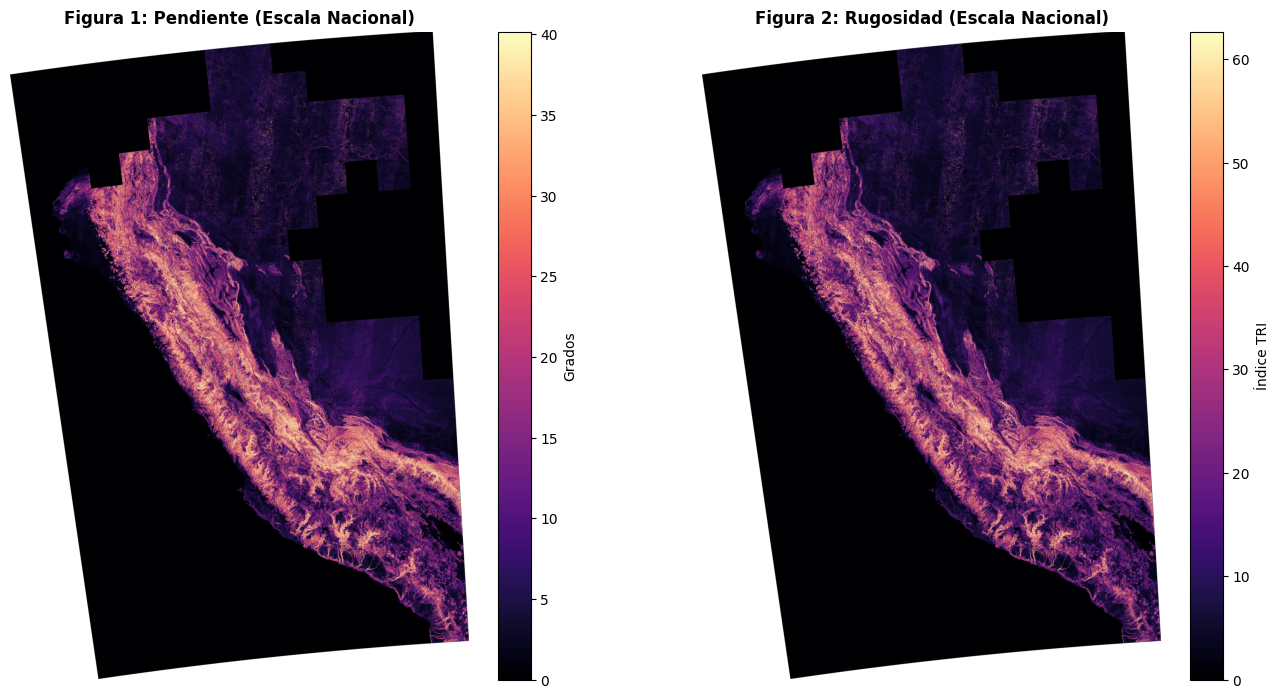

In [3]:
# 1. Configuración de rutas (ajustadas a tu estructura)
capas = {
    'Pendiente': '../data/processed/102033/raster_pendiente.tif',
    'Rugosidad': '../data/processed/102033/raster_rugosidad.tif'
}

fig, axes = plt.subplots(1, 2, figsize=(15, 7), dpi=100)
axes = axes.flatten()

for i, (titulo, ruta) in enumerate(capas.items()):
    if os.path.exists(ruta):
        with rasterio.open(ruta) as src:
            # LECTURA SEGURA: Muestreo al 10% para no saturar RAM
            # Reducimos de ~45,000px a ~4,500px, suficiente para un gráfico de alta calidad
            data = src.read(1, out_shape=(1, src.height // 10, src.width // 10))
            
            # Limpieza de valores NoData y outliers para el artículo
            nodata = src.nodata
            data_viz = data.astype('float32')
            data_viz[data_viz == nodata] = np.nan
            
            # Definir límites visuales basados en percentiles (estándar científico)
            v_min = np.nanpercentile(data_viz, 1)
            v_max = np.nanpercentile(data_viz, 99)

            im = axes[i].imshow(data_viz, cmap='magma', vmin=v_min, vmax=v_max)
            
            # Estética de la publicación
            cbar = fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
            cbar.set_label('Grados' if titulo == 'Pendiente' else 'Índice TRI')
            
            axes[i].set_title(f"Figura {i+1}: {titulo} (Escala Nacional)", fontsize=12, fontweight='bold')
            axes[i].axis('off')
    else:
        print(f"Error: No se encontró {ruta}")

plt.tight_layout()
plt.show()

#### **2.2 Visualizacion y validacion de capas de distancia**
Se representan las distancias euclidianas hacia recursos hídricos y elementos culturales. El gradiente Viridis muestra la proximidad: los tonos oscuros indican cercanía inmediata, facilitando la identificación de zonas con mayor potencial de conectividad y recursos.

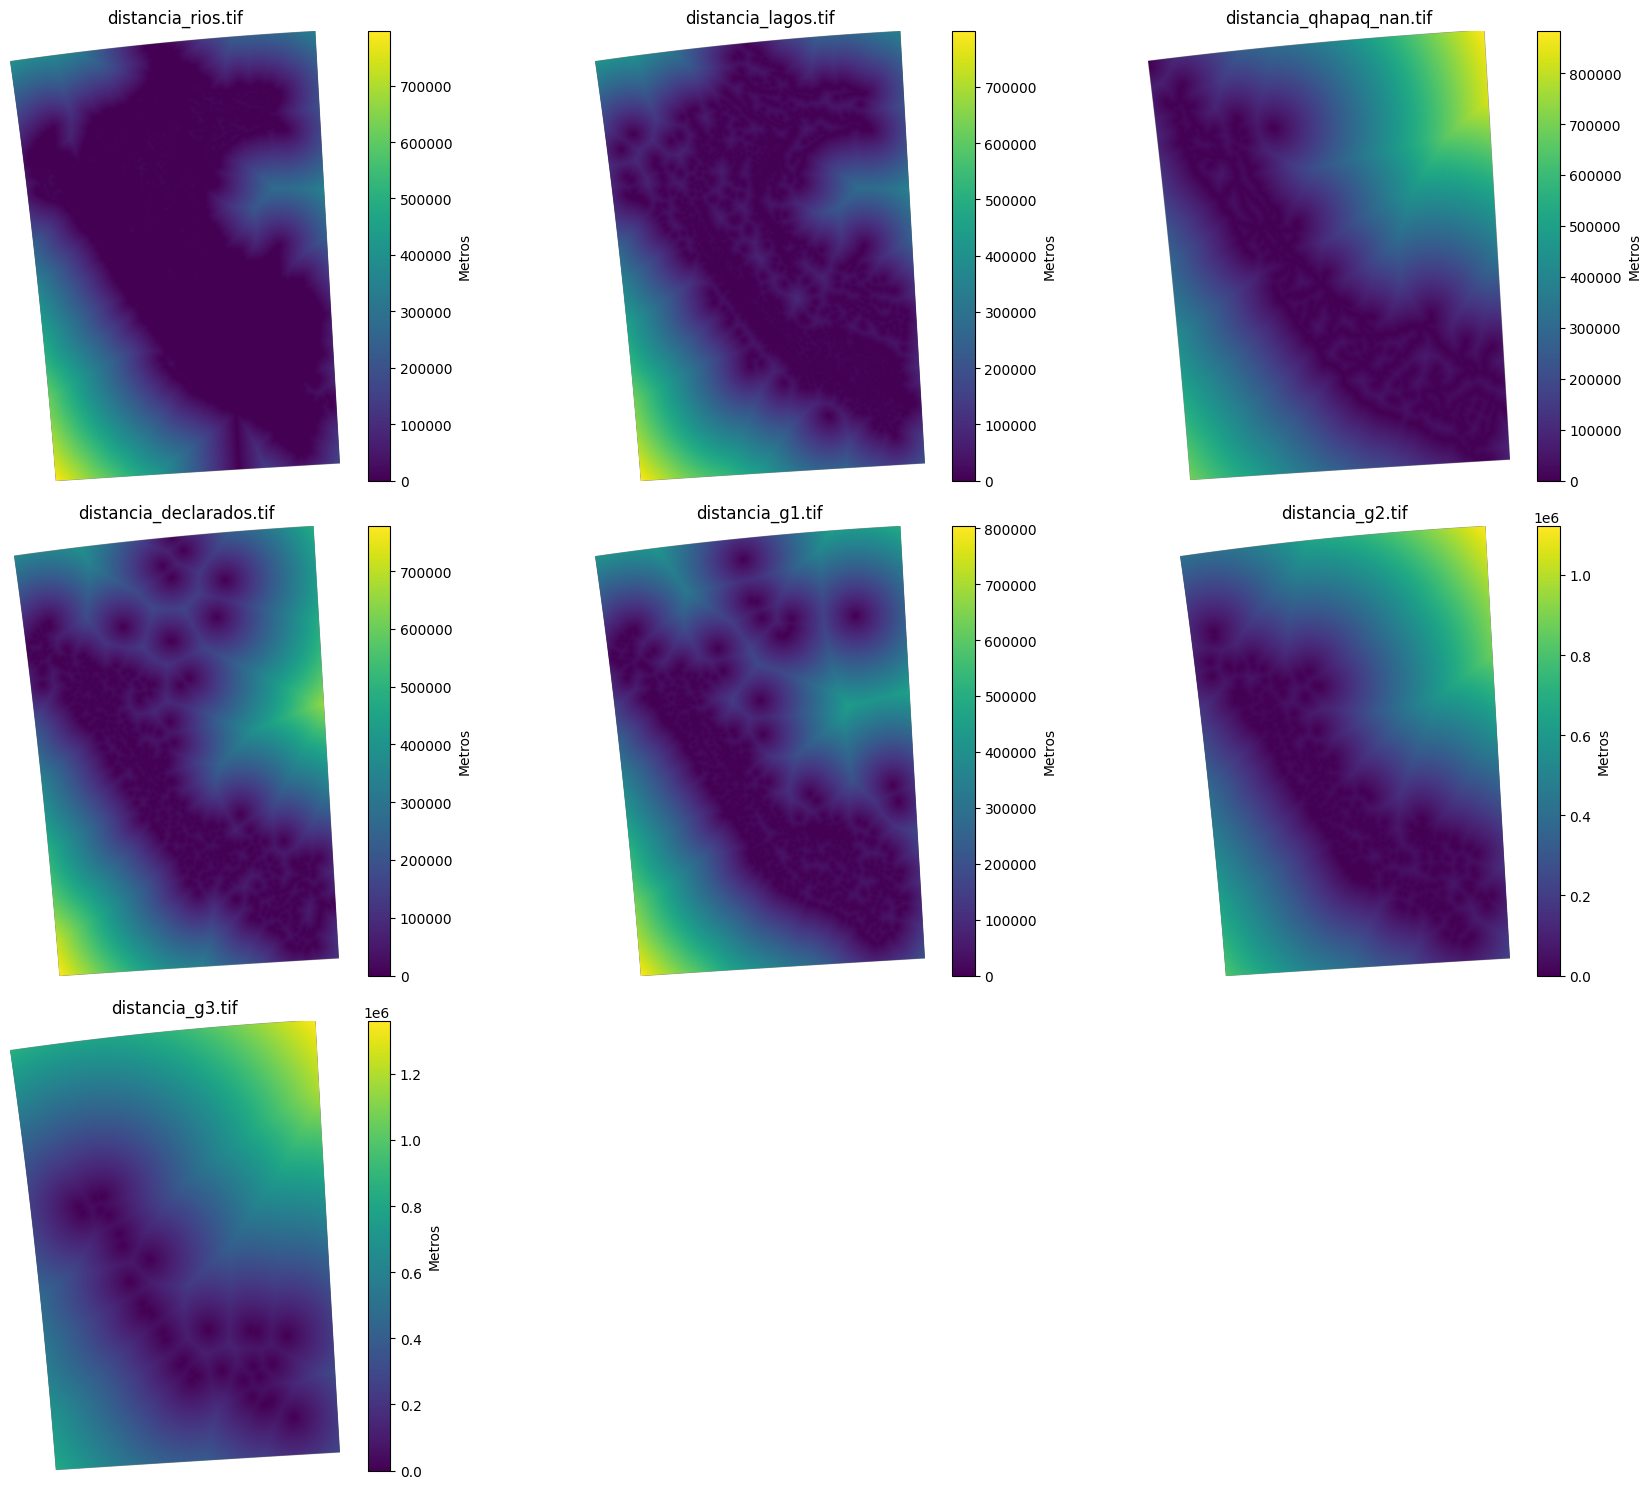

In [5]:
# Lista actualizada con los 7 archivos
capas_distancia = [
    '../data/processed/102033/distancia_rios.tif', '../data/processed/102033/distancia_lagos.tif',
    '../data/processed/102033/distancia_qhapaq_nan.tif', '../data/processed/102033/distancia_declarados.tif',
    '../data/processed/102033/distancia_g1.tif', '../data/processed/102033/distancia_g2.tif', '../data/processed/102033/distancia_g3.tif',
]

# Ajustamos a 3x3 para que quepan los 7 (sobrarán 2 espacios)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, ruta in enumerate(capas_distancia):
    with rasterio.open(ruta) as src:
        # Lectura al 10% para proteger la RAM de los 58GB
        data = src.read(1, out_shape=(1, int(src.height // 10), int(src.width // 10)))
        # --- LAS DOS LÍNEAS DE AJUSTE ---
        data = np.where(data == src.nodata, np.nan, data) # Ignora el vacío
        v_max = np.nanpercentile(data, 98)                # Ignora valores extremos
        # -------------------------------
        im = axes[i].imshow(data, cmap='viridis')
        plt.colorbar(im, ax=axes[i], label='Metros')
        axes[i].set_title(os.path.basename(ruta))
        axes[i].axis('off')

# Ocultamos los cuadros que sobraron (el 8 y el 9)
for j in range(len(capas_distancia), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### **3 Estandarización y Alineación de Capas (Snapping)**

Para que el modelo de Machine Learning funcione, todos los píxeles de todas las capas deben coincidir exactamente en el espacio. 

**Problema:** Las capas actuales tienen diferencias decimales en su resolución (ej. 30.00004m vs 30.0m), lo que impide un análisis de matriz exacto.

**Solución:**
1. Definimos el `raster_pendiente.tif` como **Capa Maestra** (Referencia) por tener los 30.0m exactos.
2. Reproyectamos y alineamos todas las demás capas para que coincidan con la extensión, resolución y sistema de coordenadas de la maestra.
3. Aplicamos compresión **LZW** para optimizar el espacio en disco.
4. Los archivos nuevos tendrán el prefijo `align_` para diferenciarlos.

In [2]:
# 1. Definimos la capa maestra (la que tiene 30.0m exactos)
maestra_path = '../data/processed/102033/raster_pendiente.tif'
ds_maestra = gdal.Open(maestra_path)
geotransform = ds_maestra.GetGeoTransform()
res_x, res_y = geotransform[1], abs(geotransform[5])
extent = [geotransform[0], 
          geotransform[3] + geotransform[5] * ds_maestra.RasterYSize,
          geotransform[0] + geotransform[1] * ds_maestra.RasterXSize,
          geotransform[3]]

# 2. Lista de capas a alinear (excluyendo la maestra)
capas_a_alinear = [
    '../data/processed/102033/distancia_rios.tif',
    '../data/processed/102033/distancia_lagos.tif',
    '../data/processed/102033/distancia_qhapaq_nan.tif',
    '../data/processed/102033/distancia_declarados.tif',
    '../data/processed/102033/distancia_g1.tif',
    '../data/processed/102033/distancia_g2.tif',
    '../data/processed/102033/distancia_g3.tif',
    '../data/processed/102033/raster_rugosidad.tif'
]

print(f"Iniciando alineación con resolución objetivo: {res_x}m")

# Definimos la carpeta de salida (un nivel arriba de la actual de los originales)
output_dir = '../data/processed/'

for ruta_in in capas_a_alinear:
    if os.path.exists(ruta_in):
        # Extraemos solo el nombre del archivo (ej: distancia_rios.tif)
        file_name = os.path.basename(ruta_in)
        # La nueva ruta será data/processed/align_distancia_rios.tif
        ruta_out = os.path.join(output_dir, f"align_{file_name}")
        
        gdal.Warp(ruta_out, ruta_in, 
                  dstSRS='ESRI:102033',
                  xRes=res_x, yRes=res_y,
                  outputBounds=extent,
                  resampleAlg='bilinear',
                  creationOptions=['COMPRESS=LZW', 'TILED=YES', 'BIGTIFF=YES'])
        
        print(f"Completado y guardado en: {ruta_out}")

/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/osgeo/gdal.py:606: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Iniciando alineación con resolución objetivo: 30.0m
Completado y guardado en: ../data/processed/align_distancia_rios.tif
Completado y guardado en: ../data/processed/align_distancia_lagos.tif
Completado y guardado en: ../data/processed/align_distancia_qhapaq_nan.tif
Completado y guardado en: ../data/processed/align_distancia_declarados.tif
Completado y guardado en: ../data/processed/align_distancia_g1.tif
Completado y guardado en: ../data/processed/align_distancia_g2.tif
Completado y guardado en: ../data/processed/align_distancia_g3.tif
Completado y guardado en: ../data/processed/align_raster_rugosidad.tif


In [8]:
# Lista de archivos basada en tu tabla de variables
archivos_raster = [
    '../data/processed/102033/raster_pendiente.tif',
    '../data/processed/align_raster_rugosidad.tif',
    '../data/processed/align_distancia_lagos.tif',
    '../data/processed/align_distancia_rios.tif',
    '../data/processed/align_distancia_qhapaq_nan.tif',
    '../data/processed/align_distancia_declarados.tif',
    '../data/processed/align_distancia_g1.tif',
    '../data/processed/align_distancia_g2.tif',
    '../data/processed/align_distancia_g3.tif'
]



print("--- Verificando Fuentes de Datos Geoespaciales ---")
for ruta in archivos_raster:
    if os.path.exists(ruta):
        with rasterio.open(ruta) as src:
            # Validamos que la resolución sea de 30m como dice tu texto
            res_x, res_y = src.res
            print(f" {os.path.basename(ruta)} | Res: {res_x}m | CRS: {src.crs}")
    else:
        print(f"ADVERTENCIA: No se encontró el archivo en: {ruta}")

--- Verificando Fuentes de Datos Geoespaciales ---
 raster_pendiente.tif | Res: 30.0m | CRS: ESRI:102033
 align_raster_rugosidad.tif | Res: 30.0m | CRS: ESRI:102033
 align_distancia_lagos.tif | Res: 30.0m | CRS: ESRI:102033
 align_distancia_rios.tif | Res: 30.0m | CRS: ESRI:102033
 align_distancia_qhapaq_nan.tif | Res: 30.0m | CRS: ESRI:102033
 align_distancia_declarados.tif | Res: 30.0m | CRS: ESRI:102033
 align_distancia_g1.tif | Res: 30.0m | CRS: ESRI:102033
 align_distancia_g2.tif | Res: 30.0m | CRS: ESRI:102033
 align_distancia_g3.tif | Res: 30.0m | CRS: ESRI:102033


#### **5.1 Estrategia de Muestreo de la Variable Dependiente ($Y=1$)**

La definición de la clase positiva (Presencia Arqueológica) se construye mediante la integración de registros puntuales y la vectorización inversa de superficies de zonificación. Dado el desbalance espacial entre grandes complejos monumentales y hallazgos aislados, se aplica un protocolo de **Muestreo Estratificado Aleatorio**:

1.  **Fuente de Datos Híbrida:**
    * **Sitios Declarados (Puntos):** Se integran la totalidad de los centroides registrados ($N_{total}$).
    * **Áreas Delimitadas (Zonas G1, G2, G3):** Se identifican los píxeles con valor $0$ en los rásteres de distancia euclidiana, los cuales representan el interior de los polígonos originales.

2.  **Muestreo por Cuotas (Quota Sampling):**
    Para mitigar el sesgo de área (*Area Bias*), donde sitios extensos (ej. Chan Chan) podrían dominar la muestra de entrenamiento, se establecen cuotas máximas de extracción de píxeles por categoría:
    * **Zona G1 (Monumental):** Muestreo denso (Límite: 5,000 píxeles aleatorios distribuidos nacionalmente).
    * **Zona G2 (Paisaje):** Muestreo medio (Límite: 3,000 píxeles).
    * **Zona G3 (Puntual):** Muestreo específico (Límite: 1,000 píxeles).

3.  **Validación Espacial:**
    Todas las coordenadas extraídas se someten a un proceso de alineación a la rejilla base (30m) y eliminación de duplicados espaciales (*Spatial Deduplication*), asegurando que cada observación en el dataset corresponda a una unidad mínima de análisis única.

In [9]:
# ==============================================================================
# 1. CONFIGURACIÓN DE RUTAS Y CUOTAS
# ==============================================================================
# Rutas de entrada
ruta_puntos_shp = '../data/raw/sitiosarqueologicos/declarados/declarados.shp'  # Tu archivo de puntos recuperado

# Usamos tus nuevos TIFs alineados. El valor 0.0 significa "dentro del sitio"
rasters_zonas = {
    'G1': '../data/processed/align_distancia_g1.tif',
    'G2': '../data/processed/align_distancia_g2.tif',
    'G3': '../data/processed/align_distancia_g3.tif'
}

# CUOTAS DE MUESTREO (Aquí definimos la "cantidad de datos")
# Esto asegura que tomemos muestras de todo el Perú uniformemente sin explotar la RAM
cuotas_muestreo = {
    'G1': 5000,   # Máximo 5000 puntos para Monumentales
    'G2': 3000,   # Máximo 3000 puntos para Paisajes
    'G3': 1000    # Máximo 1000 puntos para Evidencias
}

lista_dataframes = []

# ==============================================================================
# 2. PROCESAMIENTO DE PUNTOS DECLARADOS (SHP)
# ==============================================================================
print("--- Paso 1: Procesando Puntos Declarados (SHP) ---")
if os.path.exists(ruta_puntos_shp):
    gdf = gpd.read_file(ruta_puntos_shp)
    # Forzamos proyección 102033
    if gdf.crs != 'ESRI:102033':
        gdf = gdf.to_crs('ESRI:102033')
    
    # Extraemos coordenadas
    df_pt = pd.DataFrame({
        'X_102033': gdf.geometry.x,
        'Y_102033': gdf.geometry.y,
        'Origen': 'Sitio_Declarado',
        'Target': 1
    })
    lista_dataframes.append(df_pt)
    print(f"✅ Se agregaron {len(df_pt)} puntos declarados.")
else:
    print("⚠️ No se encontró el archivo de puntos declarados.")

# ==============================================================================
# 3. EXTRACCIÓN INTELIGENTE DESDE RASTERS (Reemplazo de Polígonos)
# ==============================================================================
print("\n--- Paso 2: Escaneando Rasters para recuperar G1, G2, G3 ---")

for zona, ruta in rasters_zonas.items():
    if os.path.exists(ruta):
        print(f"📡 Analizando {zona} ({ruta})...")
        coord_temp = []
        
        with rasterio.open(ruta) as src:
            # Leemos por bloques para no matar la memoria RAM
            # Buscamos píxeles donde valor <= 0 (o muy cercano a 0)
            for ji, window in tqdm(list(src.block_windows(1))):
                data = src.read(1, window=window)
                
                # Mascara: valores donde la distancia es 0 (dentro del sitio)
                # Usamos < 1.0 para ser tolerantes con decimales
                mask = (data >= 0) & (data < 1.0)
                
                if np.any(mask):
                    # Obtener índices relativos
                    rows, cols = np.where(mask)
                    # Convertir a coordenadas globales
                    xs, ys = src.xy(rows + window.row_off, cols + window.col_off)
                    
                    # Guardamos pares de coordenadas
                    # Usamos extend para velocidad
                    coord_temp.extend(list(zip(xs, ys)))
        
        # --- APLICACIÓN DEL MUESTREO ---
        total_encontrados = len(coord_temp)
        cuota = cuotas_muestreo.get(zona, 1000)
        
        df_zona = pd.DataFrame(coord_temp, columns=['X_102033', 'Y_102033'])
        
        if total_encontrados > cuota:
            # Aquí está la clave: SAMPLE aleatorio uniforme sobre todo lo encontrado
            df_zona = df_zona.sample(n=cuota, random_state=42)
            print(f"  🔹 {zona}: Se encontraron {total_encontrados} píxeles -> Muestreados a {cuota} (Uniforme)")
        else:
            print(f"  🔹 {zona}: Se encontraron {total_encontrados} píxeles -> Se conservan todos.")
            
        df_zona['Origen'] = f'Zona_{zona}'
        df_zona['Target'] = 1
        lista_dataframes.append(df_zona)

# ==============================================================================
# 4. UNIFICACIÓN Y LIMPIEZA
# ==============================================================================
print("\n--- Paso 3: Unificación Final ---")
if lista_dataframes:
    df_final = pd.concat(lista_dataframes, ignore_index=True)
    
    # Snap-to-Grid: Redondeamos a la rejilla de 30m para eliminar duplicados
    # Ejemplo: Si un punto declarado cae sobre un pixel G1 seleccionado, borramos uno.
    df_final['x_snap'] = (df_final['X_102033'] // 30) * 30
    df_final['y_snap'] = (df_final['Y_102033'] // 30) * 30
    
    inicial = len(df_final)
    df_final = df_final.drop_duplicates(subset=['x_snap', 'y_snap'])
    final = len(df_final)
    
    # Guardamos solo lo necesario
    df_export = df_final[['X_102033', 'Y_102033', 'Origen', 'Target']]
    
    ruta_salida = '../data/processed/dataset_presencias_Y1.csv'
    df_export.to_csv(ruta_salida, index=False)
    
    print(f"✨ Proceso Terminado. Dataset generado.")
    print(f"   Originales: {inicial} | Únicos Finales: {final}")
    print(f"   Archivo guardado en: {ruta_salida}")
    print("\nDistribución por Origen:")
    print(df_export['Origen'].value_counts())
else:
    print("❌ Error: No se generaron datos.")

--- Paso 1: Procesando Puntos Declarados (SHP) ---
✅ Se agregaron 5890 puntos declarados.

--- Paso 2: Escaneando Rasters para recuperar G1, G2, G3 ---
📡 Analizando G1 (../data/processed/align_distancia_g1.tif)...


100%|██████████| 62160/62160 [02:35<00:00, 400.10it/s] 


  🔹 G1: Se encontraron 8083646 píxeles -> Muestreados a 5000 (Uniforme)
📡 Analizando G2 (../data/processed/align_distancia_g2.tif)...


100%|██████████| 62160/62160 [02:26<00:00, 425.03it/s] 


  🔹 G2: Se encontraron 11739270 píxeles -> Muestreados a 3000 (Uniforme)
📡 Analizando G3 (../data/processed/align_distancia_g3.tif)...


100%|██████████| 62160/62160 [02:23<00:00, 433.74it/s] 

  🔹 G3: Se encontraron 849 píxeles -> Se conservan todos.

--- Paso 3: Unificación Final ---
✨ Proceso Terminado. Dataset generado.
   Originales: 14739 | Únicos Finales: 14635
   Archivo guardado en: ../data/processed/dataset_presencias_Y1.csv

Distribución por Origen:
Origen
Sitio_Declarado    5786
Zona_G1            5000
Zona_G2            3000
Zona_G3             849
Name: count, dtype: int64


#### **5.2 Generación de Datos de Fondo (Pseudo-ausencias)**

Para mitigar el sesgo inherente a los registros de "Solo Presencia" (*Presence-Only*), se implementó una estrategia de generación de **Pseudo-ausencias ($Y=0$)** mediante Muestreo Aleatorio Espacial (*Spatial Random Sampling*). Este enfoque busca caracterizar el espacio ambiental disponible en el territorio peruano que no está asociado a evidencia arqueológica conocida.

1.  **Marco de Muestreo:**
    Se definió el límite administrativo oficial del Perú (proyectado en *ESRI:102033*) como el universo espacial acotado ($S$).

2.  **Algoritmo de Generación (Target Shooting):**
    Se generaron coordenadas aleatorias $(x, y)$ siguiendo una distribución uniforme dentro de la caja delimitadora (*Bounding Box*) del territorio nacional. Cada coordenada candidata fue sometida a un proceso de validación en dos etapas:
    * **Validación Geométrica:** Se conservaron únicamente los puntos ubicados estrictamente dentro del polígono del Perú (excluyendo océano y países limítrofes).
    * **Filtro de Exclusión:** Se descartaron aquellos puntos que coincidieran espacialmente (en una rejilla de $30 \times 30m$) con sitios arqueológicos confirmados ($Y=1$), garantizando la independencia entre clases.

3.  **Balance de Clases:**
    El proceso iterativo concluyó al alcanzar un ratio de **1:1** respecto al conjunto de presencias ($N_{ausencias} = N_{presencias}$), asegurando un dataset balanceado para maximizar la capacidad discriminante de los algoritmos de clasificación.

In [4]:
# ==============================================================================
# 1. CONFIGURACIÓN
# ==============================================================================
ruta_presencias = '../data/processed/dataset_presencias_Y1.csv'
possible_masks = [
    '../data/processed/align_raster_pendiente.tif',
    '../data/processed/102033/raster_pendiente.tif'
]
ruta_mask = next((r for r in possible_masks if os.path.exists(r)), None)

if not ruta_mask:
    raise FileNotFoundError("❌ No encuentro el raster de pendiente (máscara).")

print("--- 1. Preparando objetivos ---")
df_si = pd.read_csv(ruta_presencias)
n_objetivo = len(df_si)
print(f"🎯 Meta: {n_objetivo} puntos (Distribución totalmente aleatoria).")

# Blacklist de sitios (Coordenadas enteras para búsqueda rápida)
set_presencias = set(zip(
    (pd.to_numeric(df_si['X_102033'], errors='coerce') // 30).fillna(0).astype(int) * 30, 
    (pd.to_numeric(df_si['Y_102033'], errors='coerce') // 30).fillna(0).astype(int) * 30
))

# ==============================================================================
# 2. CARGAR LÍMITES DE PERÚ
# ==============================================================================
print("--- 2. Obteniendo límites geográficos ---")
url_mapa = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url_mapa)
peru_gdf = world[world['ADMIN'] == "Peru"].to_crs("ESRI:102033")
peru_geom = peru_gdf.geometry.values[0]
peru_optimizado = prep(peru_geom) # Optimización de velocidad

# Límites de la caja (Bounding Box) para lanzar los dardos
minx, miny, maxx, maxy = peru_gdf.total_bounds

# ==============================================================================
# 3. GENERACIÓN "TIRO AL BLANCO" (Sin leer el raster entero)
# ==============================================================================
ausencias_validas = []
batch_size = 50000  # Probamos de a 50 mil puntos
pbar = tqdm(total=n_objetivo)

print("\n--- 3. Generando coordenadas aleatorias ---")

with rasterio.open(ruta_mask) as src:
    while len(ausencias_validas) < n_objetivo:
        # A. Generar coordenadas aleatorias en la caja de Perú
        x_rand = np.random.uniform(minx, maxx, batch_size)
        y_rand = np.random.uniform(miny, maxy, batch_size)
        
        candidatos = []
        
        # B. Verificar contra el RASTER (¿Es tierra firme?)
        # sample() es muy eficiente, pincha el archivo sin cargarlo
        coords_to_sample = list(zip(x_rand, y_rand))
        for (x, y), val in zip(coords_to_sample, src.sample(coords_to_sample)):
            # Si el valor no es NoData (asumimos que nodata es negativo o muy grande)
            # Ajusta esto si tu nodata es específico (ej. -9999)
            if val[0] != src.nodata:
                 candidatos.append((x, y))
        
        # C. Filtrado Geométrico Fino
        for x, y in candidatos:
            if len(ausencias_validas) >= n_objetivo: break
            
            # 1. ¿Está dentro del polígono exacto de Perú?
            if peru_optimizado.contains(Point(x, y)):
                
                # 2. ¿Choca con un sitio arqueológico?
                x_grid = int(x // 30) * 30
                y_grid = int(y // 30) * 30
                
                if (x_grid, y_grid) not in set_presencias:
                    ausencias_validas.append({'X_102033': x, 'Y_102033': y})
                    pbar.update(1)

pbar.close()

# ==============================================================================
# 4. GUARDADO
# ==============================================================================
df_final = pd.DataFrame(ausencias_validas)
df_final['Origen'] = 'Pseudo_Ausencia'
df_final['Target'] = 0

ruta_salida = '../data/processed/dataset_ausencias_Y0.csv'
df_final.to_csv(ruta_salida, index=False)
print(f"\n✅ ¡CORREGIDO! {len(df_final)} puntos generados aleatoriamente.")
print(f"💾 Guardado en: {ruta_salida}")

--- 1. Preparando objetivos ---
🎯 Meta: 14635 puntos (Distribución totalmente aleatoria).
--- 2. Obteniendo límites geográficos ---


  0%|          | 0/14635 [00:00<?, ?it/s]


--- 3. Generando coordenadas aleatorias ---


100%|██████████| 14635/14635 [01:04<00:00, 227.68it/s]



✅ ¡CORREGIDO! 14635 puntos generados aleatoriamente.
💾 Guardado en: ../data/processed/dataset_ausencias_Y0.csv


#### **5.3 Validacion visual (Mapa de Visualizacion)**
Distribución espacial de las muestras de entrenamiento. Los puntos rojos (Y=1) representan la evidencia arqueológica positiva (sitios puntuales y muestreo de polígonos). Los puntos azules (Y=0) representan las pseudo-ausencias generadas aleatoriamente dentro del territorio nacional, excluyendo las zonas de influencia arqueológica conocida. Los polígonos grises indican las zonas arqueológicas delimitadas oficiales.

🎨 Preparando capas y verificando proyecciones...
⚠️ Reproyectando polígonos de EPSG:4326 a ESRI:102033...


/tmp/ipykernel_5067/2952967143.py:96: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  leg = ax.legend(loc='lower left', frameon=True, fontsize=11, markerscale=6)


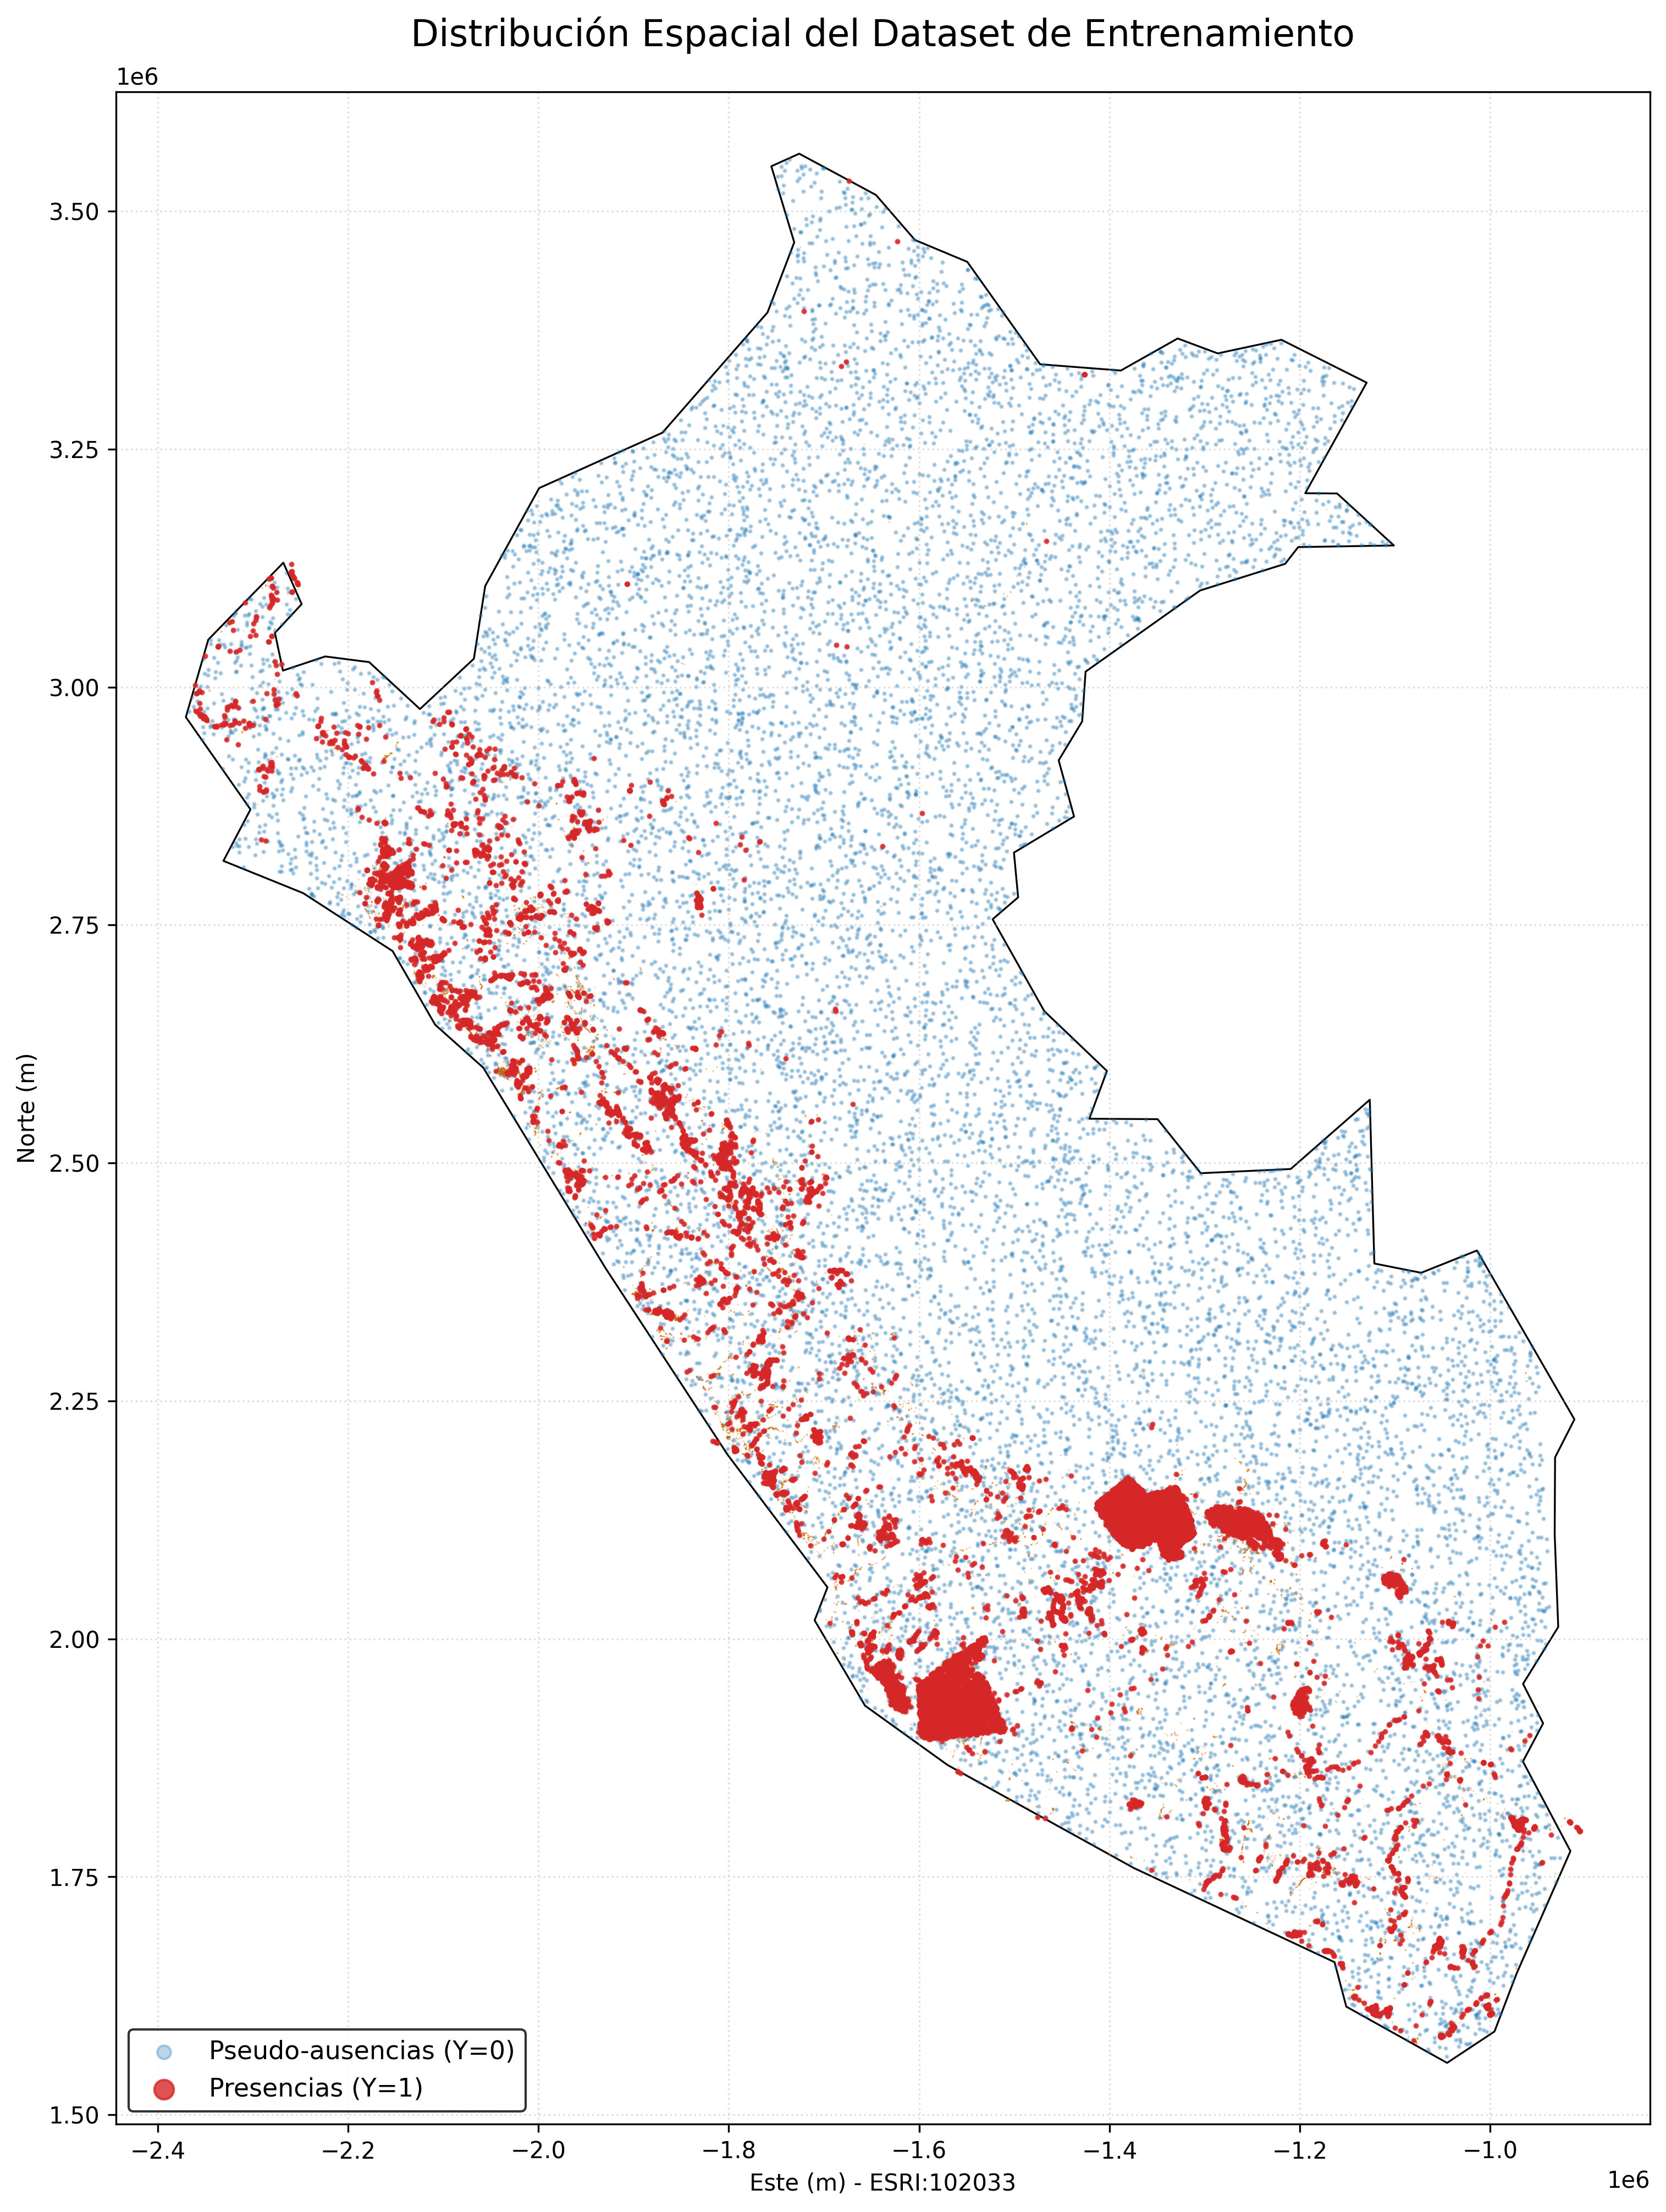

✅ Figura guardada correctamente en: ../data/processed/figura_distribucion_final.png


In [9]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches

# ==============================================================================
# 1. CARGA Y REPROYECCIÓN DE DATOS
# ==============================================================================
# Rutas
ruta_delimitados = '../data/raw/sitiosarqueologicos/delimitados/delimitados.shp'
ruta_si = '../data/processed/dataset_presencias_Y1.csv'
ruta_no = '../data/processed/dataset_ausencias_Y0.csv'

print("🎨 Preparando capas y verificando proyecciones...")

# A. Cargar Puntos (CSV -> GeoDataFrame)
df_si = pd.read_csv(ruta_si)
df_no = pd.read_csv(ruta_no)

gdf_si = gpd.GeoDataFrame(
    df_si, geometry=gpd.points_from_xy(df_si.X_102033, df_si.Y_102033), crs="ESRI:102033"
)
gdf_no = gpd.GeoDataFrame(
    df_no, geometry=gpd.points_from_xy(df_no.X_102033, df_no.Y_102033), crs="ESRI:102033"
)

# B. Cargar Polígonos (SHP) y Reproyectar
if os.path.exists(ruta_delimitados):
    gdf_delimitados = gpd.read_file(ruta_delimitados)
    
    # --- AQUÍ ESTÁ LA CORRECCIÓN CLAVE ---
    # Si no está en 102033, lo forzamos.
    if gdf_delimitados.crs != "ESRI:102033":
        print(f"⚠️ Reproyectando polígonos de {gdf_delimitados.crs} a ESRI:102033...")
        gdf_delimitados = gdf_delimitados.to_crs("ESRI:102033")
    else:
        print("✅ Los polígonos ya están en la proyección correcta.")
else:
    gdf_delimitados = None
    print("❌ No se encontró el archivo de polígonos.")

# C. Cargar Borde de Perú
try:
    url_mapa = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url_mapa)
    peru_borde = world[world['ADMIN'] == "Peru"].to_crs("ESRI:102033")
except:
    peru_borde = None

# ==============================================================================
# 2. GENERACIÓN DEL GRÁFICO CIENTÍFICO
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 16), dpi=300)

# Capa 1: Frontera Perú (Fondo base)
if peru_borde is not None:
    peru_borde.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8, zorder=0)

# Capa 2: Zonas Delimitadas (Polígonos) - COLOR ÁMBAR/NARANJA
# Usamos 'label' para que salga en la leyenda automáticamente
if gdf_delimitados is not None:
    gdf_delimitados.plot(ax=ax, 
                         color='#ff7f0e', # Naranja visible
                         edgecolor='#cc6600', 
                         linewidth=0.5,
                         alpha=0.5,       # Transparencia para ver si hay puntos debajo
                         label='Zonas Delimitadas (Polígonos)', 
                         zorder=2) # Encima del mapa, debajo de los puntos

# Capa 3: Ausencias (Azul)
gdf_no.plot(ax=ax, 
            markersize=1, 
            color='#1f77b4', 
            alpha=0.3, 
            label='Pseudo-ausencias (Y=0)', 
            zorder=1) # Fondo de puntos

# Capa 4: Presencias (Rojo)
gdf_si.plot(ax=ax, 
            markersize=2, # Un poco más grandes para destacar
            color='#d62728', 
            alpha=0.8, 
            label='Presencias (Y=1)', 
            zorder=3) # Arriba de todo

# ==============================================================================
# 3. LEYENDA Y DETALLES
# ==============================================================================
plt.title("Distribución Espacial del Dataset de Entrenamiento", fontsize=16, pad=20)
plt.xlabel("Este (m) - ESRI:102033", fontsize=10)
plt.ylabel("Norte (m)", fontsize=10)

# Personalizar Leyenda para que sea legible
# Forzamos que aparezcan los elementos con marcadores grandes
leg = ax.legend(loc='lower left', frameon=True, fontsize=11, markerscale=6)
leg.get_frame().set_edgecolor('black')

plt.grid(True, linestyle=':', alpha=0.4)
plt.axis('equal')

# Guardar
ruta_fig = '../data/processed/figura_distribucion_final.png'
plt.savefig(ruta_fig, bbox_inches='tight', dpi=300)
plt.show()

print(f"✅ Figura guardada correctamente en: {ruta_fig}")

#### **5.3 Extracción de variable (Pixel Drilling)**

In [11]:
print("--- ⛏️ INICIANDO PIXEL DRILLING (Fase 5.3) ---")

# ==============================================================================
# 1. CARGA Y UNIFICACIÓN
# ==============================================================================
ruta_si = '../data/processed/dataset_presencias_Y1.csv'
ruta_no = '../data/processed/dataset_ausencias_Y0.csv'

if os.path.exists(ruta_si) and os.path.exists(ruta_no):
    df_si = pd.read_csv(ruta_si)
    df_no = pd.read_csv(ruta_no)
    
    # Unir ambos datasets (Presencias + Ausencias)
    df_master = pd.concat([df_si, df_no], ignore_index=True)
    print(f"📊 Total de puntos a procesar: {len(df_master)}")
    print(f"   - Presencias (1): {len(df_si)}")
    print(f"   - Ausencias (0):  {len(df_no)}")
else:
    raise FileNotFoundError("Faltan los archivos CSV de puntos (Paso 5.1 o 5.2).")

# ==============================================================================
# 2. DEFINICIÓN DE VARIABLES (Tus Mapas)
# ==============================================================================
# ¡IMPORTANTE! Verifica que estos nombres sean EXACTOS a tus archivos
rasters = {
    'pendiente':   '../data/processed/102033/raster_pendiente.tif',
    'rugosidad':   '../data/processed/align_raster_rugosidad.tif',
    'dist_rios':   '../data/processed/align_distancia_rios.tif',
    'dist_lagos':  '../data/processed/align_distancia_lagos.tif',
    'dist_qhapaq': '../data/processed/align_distancia_qhapaq_nan.tif',
    'dist_g1':     '../data/processed/align_distancia_g1.tif',
    'dist_g2':     '../data/processed/align_distancia_g2.tif',
    'dist_g3':     '../data/processed/align_distancia_g3.tif'
}

# Verificación de existencia de archivos antes de empezar
for nombre, ruta in rasters.items():
    if not os.path.exists(ruta):
        # Intentar buscar en subcarpeta 102033 si no está en processed
        ruta_alt = ruta.replace('/processed/', '/processed/102033/')
        if os.path.exists(ruta_alt):
            rasters[nombre] = ruta_alt
            print(f"✅ Encontrado (ruta alterna): {nombre}")
        else:
            print(f"❌ PELIGRO: No encuentro el mapa de '{nombre}' en {ruta}")

# ==============================================================================
# 3. EXTRACCIÓN (DRILLING)
# ==============================================================================
print("\n--- Extrayendo valores de los píxeles ---")

# Lista de coordenadas (x, y)
coords = list(zip(df_master['X_102033'], df_master['Y_102033']))

# Iteramos sobre cada mapa
for nombre_var, ruta_tif in rasters.items():
    if os.path.exists(ruta_tif):
        print(f"📍 Perforando capa: {nombre_var} ...")
        
        with rasterio.open(ruta_tif) as src:
            # src.sample() es un generador, extraemos el valor
            # sample devuelve un array (ej: [25.4]), tomamos el índice 0
            valores_extraidos = [x[0] for x in src.sample(coords)]
            
            # Asignamos al DataFrame
            df_master[nombre_var] = valores_extraidos
            
            # Convertir el valor NoData del raster a NaN de Python
            if src.nodata is not None:
                df_master.loc[df_master[nombre_var] == src.nodata, nombre_var] = np.nan
    else:
        print(f"⚠️ Saltando {nombre_var} (Archivo no encontrado)")
        df_master[nombre_var] = np.nan

# ==============================================================================
# 4. LIMPIEZA FINAL Y GUARDADO
# ==============================================================================
print("\n--- Limpieza Final ---")
n_antes = len(df_master)

# Eliminamos cualquier fila que tenga al menos un NaN (Dato incompleto)
df_final = df_master.dropna()
n_despues = len(df_final)

print(f"Filas eliminadas por datos faltantes (fuera del mapa/bordes): {n_antes - n_despues}")
print(f"✅ DATASET FINAL LISTO: {n_despues} observaciones.")

# Guardar
ruta_salida_final = '../data/features/dataset_entrenamiento.csv'
df_final.to_csv(ruta_salida_final, index=False)

print(f"🎉 ¡FELICIDADES! Tu base de datos para IA está en: {ruta_salida_final}")
print("Muestra de datos:")
print(df_final.head())

--- ⛏️ INICIANDO PIXEL DRILLING (Fase 5.3) ---
📊 Total de puntos a procesar: 29270
   - Presencias (1): 14635
   - Ausencias (0):  14635

--- Extrayendo valores de los píxeles ---
📍 Perforando capa: pendiente ...
📍 Perforando capa: rugosidad ...


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


📍 Perforando capa: dist_rios ...


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


📍 Perforando capa: dist_lagos ...


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


📍 Perforando capa: dist_qhapaq ...


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


📍 Perforando capa: dist_g1 ...


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


📍 Perforando capa: dist_g2 ...


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


📍 Perforando capa: dist_g3 ...


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)



--- Limpieza Final ---
Filas eliminadas por datos faltantes (fuera del mapa/bordes): 2223
✅ DATASET FINAL LISTO: 27047 observaciones.
🎉 ¡FELICIDADES! Tu base de datos para IA está en: ../data/features/dataset_entrenamiento.csv
Muestra de datos:
       X_102033      Y_102033           Origen  Target  pendiente  rugosidad  \
0 -1.794915e+06  2.428515e+06  Sitio_Declarado       1   2.569503   3.464102   
1 -1.780363e+06  2.414741e+06  Sitio_Declarado       1   4.431820   5.830952   
2 -1.778420e+06  2.414945e+06  Sitio_Declarado       1   4.727942   6.708204   
3 -1.791737e+06  2.426272e+06  Sitio_Declarado       1   3.372287  12.124355   
4 -1.806857e+06  2.438869e+06  Sitio_Declarado       1   5.788832   8.124039   

    dist_rios   dist_lagos  dist_qhapaq       dist_g1      dist_g2  \
0   14.581225  2741.532715    33.710812   1945.142578     0.000000   
1  948.773376    41.049797  1952.876831   2650.712158  1901.143066   
2   83.436218   524.259583     1.394819    640.499451     0.000